In [1]:
import pandas as pd
import requests
import os
import re
import time
import matplotlib.pyplot as plt

real_pep_file = "data/fullData/train_HLA_A0201.csv"     
real_hla_name = "HLA-A*02:01"             

if os.path.exists(real_pep_file):
    real_df = pd.read_csv(real_pep_file)
    # try common column names
    if "HLA" in real_df.columns and "peptide" in real_df.columns:
        real_peptides = real_df[real_df["HLA"] == real_hla_name]["peptide"].dropna().astype(str).tolist()
    elif "HLA_name" in real_df.columns and "peptide" in real_df.columns:
        real_peptides = real_df[real_df["HLA_name"] == real_hla_name]["peptide"].dropna().astype(str).tolist()
    elif "peptide" in real_df.columns:
        real_peptides = real_df["peptide"].dropna().astype(str).tolist()
    else:
        real_peptides = []
        print("Couldn't find peptide column in real-peptide file; set real_peptides manually.")
else:
    real_peptides = []
    print(f"Real peptide file not found at {real_pep_file}; set `real_peptides` manually if needed.")

print("Loaded", len(real_peptides), "real peptides for", real_hla_name)


Loaded 19109 real peptides for HLA-A*02:01


In [2]:
import pandas as pd
import requests
import os
import re
import time

# ------------------------------
# CONFIGURATION
# ------------------------------
IEDB_API_URL = "http://tools-cluster-interface.iedb.org/tools_api/mhci/"
ALLELE = "HLA-A*02:01"
METHOD = "netmhcpan-4.1"
SUPPORTED_LENGTHS = [8, 9, 10, 11]
VALID_AA = re.compile(r'^[ACDEFGHIKLMNPQRSTVWY]+$')  # standard amino acids

# File locations
GEN_FILE = "generatedPeptides/HLAA0201/generated_peptides.csv"
REAL_FILE = "data/fullData/train_HLA_A0201.csv"   
OUTPUT_DIR = "netmhcBenchmark"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------
# API Functions
# ------------------------------
def run_iedb(peptides, allele, length, method):
    payload = {
        "method": method,
        "sequence_text": "\n".join(peptides),
        "allele": allele,
        "length": length
    }
    try:
        r = requests.post(IEDB_API_URL, data=payload, timeout=60)
        r.raise_for_status()
        lines = r.text.strip().split("\n")
        headers = lines[0].split("\t")
        rename_map = {"percentile_rank": "Rank", "ic50": "Aff"} if "percentile_rank" in headers else {}
        df = pd.DataFrame([l.split("\t") for l in lines[1:]], columns=headers)
        df = df.rename(columns=rename_map)
        if "Rank" in df.columns:
            df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
        if "Aff" in df.columns:
            df["Aff"] = pd.to_numeric(df["Aff"], errors="coerce")
        return df
    except Exception as e:
        print(f"API error (len={length}): {e}")
        return None

def run_iedb_batched(peptides, allele, length, method, batch_size=500, delay=1.0):
    all_results = []
    for i in range(0, len(peptides), batch_size):
        batch = peptides[i:i+batch_size]
        print(f"Submitting batch {i//batch_size+1} ({len(batch)} peptides, len={length})...")
        df = run_iedb(batch, allele, length, method)
        if df is not None:
            all_results.append(df)
        time.sleep(delay) 
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return None

# ------------------------------
# Load and run generated peptides
# ------------------------------
if os.path.exists(GEN_FILE):
    gen_df = pd.read_csv(GEN_FILE)
    gen_df = gen_df[gen_df["peptide"].str.match(VALID_AA)]
    gen_df["length"] = gen_df["peptide"].str.len()
    for length in sorted(set(gen_df["length"]) & set(SUPPORTED_LENGTHS)):
        peps = gen_df[gen_df["length"] == length]["peptide"].tolist()
        print(f"Processing GENERATED peptides length {length} ({len(peps)})...")
        results = run_iedb_batched(peps, ALLELE, length, METHOD)
        if results is not None:
            results.to_csv(f"{OUTPUT_DIR}/results_len{length}.csv", index=False)

# ------------------------------
# Load and run real peptides
# ------------------------------
if os.path.exists(REAL_FILE):
    real_df = pd.read_csv(REAL_FILE)
    if "HLA" in real_df.columns and "peptide" in real_df.columns:
        real_peptides = real_df[real_df["HLA"] == ALLELE]["peptide"].dropna().astype(str).tolist()
    elif "HLA_name" in real_df.columns and "peptide" in real_df.columns:
        real_peptides = real_df[real_df["HLA_name"] == ALLELE]["peptide"].dropna().astype(str).tolist()
    else:
        real_peptides = []
    real_df = pd.DataFrame({"peptide": real_peptides})
    real_df = real_df[real_df["peptide"].str.match(VALID_AA)]
    real_df["length"] = real_df["peptide"].str.len()
    for length in sorted(set(real_df["length"]) & set(SUPPORTED_LENGTHS)):
        peps = real_df[real_df["length"] == length]["peptide"].tolist()
        print(f"Processing REAL peptides length {length} ({len(peps)})...")
        results = run_iedb_batched(peps, ALLELE, length, METHOD)
        if results is not None:
            results.to_csv(f"{OUTPUT_DIR}/results_real_len{length}.csv", index=False)

print("IEDB benchmarking complete.")


Processing GENERATED peptides length 8 (3345)...
Submitting batch 1 (500 peptides, len=8)...
Submitting batch 2 (500 peptides, len=8)...
Submitting batch 3 (500 peptides, len=8)...
Submitting batch 4 (500 peptides, len=8)...
Submitting batch 5 (500 peptides, len=8)...
Submitting batch 6 (500 peptides, len=8)...
Submitting batch 7 (345 peptides, len=8)...
Processing GENERATED peptides length 9 (70512)...
Submitting batch 1 (500 peptides, len=9)...
Submitting batch 2 (500 peptides, len=9)...
Submitting batch 3 (500 peptides, len=9)...
Submitting batch 4 (500 peptides, len=9)...
Submitting batch 5 (500 peptides, len=9)...
Submitting batch 6 (500 peptides, len=9)...
Submitting batch 7 (500 peptides, len=9)...
Submitting batch 8 (500 peptides, len=9)...
Submitting batch 9 (500 peptides, len=9)...
Submitting batch 10 (500 peptides, len=9)...
Submitting batch 11 (500 peptides, len=9)...
Submitting batch 12 (500 peptides, len=9)...
Submitting batch 13 (500 peptides, len=9)...
Submitting batch 

In [3]:
def plot_pie_distribution(df, length):
    # Define categories
    categories = {
        "Strong": df[df["Rank"] <= 0.5],
        "Weak": df[(df["Rank"] > 0.5) & (df["Rank"] <= 2.0)],
        "Non": df[df["Rank"] > 2.0]
    }
    
    counts = [len(v) for v in categories.values()]
    colors = ['#9BC995', "#083D77", '#9A031E']  # first three colors of your palette

    # Skip pie chart if all counts are zero
    if sum(counts) == 0:
        print(f"No binders found for length {length}, skipping pie chart.")
        return

    plt.figure(figsize=(6,6))
    plt.pie(
        counts,
        labels=categories.keys(),
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )
    plt.title(f"Binding Distribution (len={length})")
    plt.savefig(f"{OUTPUT_DIR}/binding_pie_len{length}.png")
    plt.close()

lengths = [8, 9, 10, 11]
for length in lengths:
    results_file = f"{OUTPUT_DIR}/results_len{length}.csv"
    if os.path.exists(results_file):
        results = pd.read_csv(results_file)
        plot_pie_distribution(results, length)
    else:
        print(f"Results file for length {length} not found, skipping pie chart.")


In [4]:
import plotly.express as px

def plot_pie_plotly(df, length):
    categories = {
        "Strong": df[df["Rank"] <= 0.5],
        "Weak": df[(df["Rank"] > 0.5) & (df["Rank"] <= 2.0)],
        "Non": df[df["Rank"] > 2.0]
    }
    counts = [len(v) for v in categories.values()]
    colors = ['#9BC995', "#083D77", '#9A031E']

    fig = px.pie(
        names=list(categories.keys()),
        values=counts,
        color=list(categories.keys()),
        color_discrete_sequence=colors,
        title=f"Binding Distribution (len={length})"
    )
    fig.update_traces(textinfo='percent+label', pull=[0.1, 0.05, 0])
    fig.write_image(f"{OUTPUT_DIR}/binding_plotly_len{length}.png")  
    fig.write_html(f"{OUTPUT_DIR}/binding_plotly_len{length}.html") 
lengths = [8, 9, 10, 11]
for length in lengths:
    results_file = f"{OUTPUT_DIR}/results_len{length}.csv"
    if os.path.exists(results_file):
        results = pd.read_csv(results_file)
        plot_pie_plotly(results, length)
    else:
        print(f"Results file for length {length} not found, skipping Plotly pie chart.")

In [14]:
def plot_all_pie_charts(lengths, output_dir):
    fig, axes = plt.subplots(1, len(lengths), figsize=(5 * len(lengths), 5))

    # Define categories and colors based on your preference
    labels = ["Strong Binder", "Weak Binder", "Non-Binder"]
    colors = ['#9BC995', '#083D77', '#9A031E']
    
    # Custom legend labels with rank thresholds
    legend_labels = [
        "Strong Binder (<0.5% Rank)",
        "Weak Binder (>0.5-2.0% Rank)",
        "Non-Binder (>2.0% Rank)"
    ]

    # Ensure axes is a list even for a single subplot
    if len(lengths) == 1:
        axes = [axes]

    # Add each pie chart to a subplot
    for i, length in enumerate(lengths):
        results_file = f"{output_dir}/results_len{length}.csv"
        if os.path.exists(results_file):
            df = pd.read_csv(results_file)
            
            strong_count = len(df[df["Rank"] <= 0.5])
            weak_count = len(df[(df["Rank"] > 0.5) & (df["Rank"] <= 2.0)])
            non_count = len(df[df["Rank"] > 2.0])
            total_peptides = len(df)
            
            counts = [strong_count, weak_count, non_count]

            # Custom function for autopct to show both count and percentage
            def autopct_format(pct):
                absolute = int(round(pct/100.*total_peptides))
                return f"{pct:.1f}%\n({absolute:d})"
                
            axes[i].pie(
                counts,
                colors=colors,
                autopct=autopct_format,
                startangle=90,
                textprops={'fontsize': 14}
            )
            axes[i].set_title(f"Length {length}\nTotal Peptides: {total_peptides}", fontsize=18)
            axes[i].axis('equal') # Equal aspect ratio ensures that pie is circular.
        else:
            print(f"Results file for length {length} not found, skipping pie chart.")

    # Create a single legend at the bottom of the figure with custom labels
    fig.legend(
        legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=len(legend_labels),
        fontsize=14
    )

    # Add a main title for the entire figure
    fig.suptitle("NetMHC Binding Distribution of Generated Peptides", fontsize=23)

    # Adjust layout to make room for the legend and subplot titles
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    output_png = f"{output_dir}/binding_all_lengths.png"
    plt.savefig(output_png, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Saved combined plot to {output_png}")

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_all_real_pie_charts(lengths, output_dir):
    """
    Creates a single figure with Matplotlib subplots for each peptide length's binding distribution
    (using the real peptide set).
    """
    fig, axes = plt.subplots(1, len(lengths), figsize=(5 * len(lengths), 5))

    # Define categories and colors
    labels = ["Strong Binder", "Weak Binder", "Non-Binder"]
    colors = ['#9BC995', '#083D77', '#9A031E']
    
    # Custom legend labels with rank thresholds
    legend_labels = [
        "Strong Binder (<0.5% Rank)",
        "Weak Binder (>0.5-2.0% Rank)",
        "Non-Binder (>2.0% Rank)"
    ]

    # Ensure axes is a list even for a single subplot
    if len(lengths) == 1:
        axes = [axes]

    # Add each pie chart to a subplot
    for i, length in enumerate(lengths):
        results_file = f"{output_dir}/results_real_len{length}.csv"
        if os.path.exists(results_file):
            df = pd.read_csv(results_file)
            
            strong_count = len(df[df["Rank"] <= 0.5])
            weak_count = len(df[(df["Rank"] > 0.5) & (df["Rank"] <= 2.0)])
            non_count = len(df[df["Rank"] > 2.0])
            total_peptides = len(df)
            
            counts = [strong_count, weak_count, non_count]

            # Custom function for autopct to show both count and percentage
            def autopct_format(pct):
                absolute = int(round(pct/100.*total_peptides))
                return f"{pct:.1f}%\n({absolute:d})"
                
            axes[i].pie(
                counts,
                colors=colors,
                autopct=autopct_format,
                startangle=90,
                textprops={'fontsize': 14}
            )
            axes[i].set_title(f"Length {length}\nTotal Peptides: {total_peptides}", fontsize=18)
            axes[i].axis('equal') # Equal aspect ratio ensures that pie is circular.
        else:
            print(f"Results file for length {length} not found, skipping pie chart.")

    # Create a single legend at the bottom of the figure with custom labels
    fig.legend(
        legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=len(legend_labels),
        fontsize=14
    )

    # Add a main title for the entire figure
    fig.suptitle("NetMHC Binding Distribution of Real Peptides", fontsize=23)

    # Adjust layout to make room for the legend and subplot titles
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    output_png = f"{output_dir}/binding_real_all_lengths.png"
    plt.savefig(output_png, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Saved combined plot to {output_png}")

# --- Execution ---
OUTPUT_DIR = "netmhcBenchmark"
lengths = [9, 10, 11]

os.makedirs(OUTPUT_DIR, exist_ok=True)
plot_all_real_pie_charts(lengths, OUTPUT_DIR)


Saved combined plot to netmhcBenchmark/binding_real_all_lengths.png


In [16]:
import Levenshtein
import pandas as pd 
from collections import Counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def min_levenshtein_distances(generated_peptides, real_peptides):
    min_dists = []
    for gen_pep in tqdm(generated_peptides, desc=f"Computing min distances vs {len(real_peptides)} real peptides"):
        dists = [Levenshtein.distance(gen_pep, real_pep) for real_pep in real_peptides]
        min_dists.append(min(dists))
    return min_dists


In [17]:
import numpy as np
from tqdm import tqdm

plot_rows = []

for length in [8, 9, 10, 11]:
    gen_file = os.path.join(OUTPUT_DIR, f"results_len{length}.csv")
    real_file = os.path.join(OUTPUT_DIR, f"results_real_len{length}.csv")

    if not os.path.exists(gen_file):
        print(f"Skipping generated len {length}: {gen_file} not found")
        continue

    # load generated results
    gen_res = pd.read_csv(gen_file)
    gen_res.columns = [c.lower() for c in gen_res.columns]
    gen_res = gen_res.set_index("peptide", drop=False)

    # generated peptides of this length
    gen_peps = gen_df[gen_df["length"] == length]["peptide"].astype(str).tolist()

    # distances against real peptides
    real_peps_len = [pep for pep in real_peptides if len(pep) == length]
    for pep in tqdm(gen_peps, desc=f"Gen len {length}"):
        dist = (min(Levenshtein.distance(pep, r) for r in real_peps_len)
                if real_peps_len else np.nan)
        row = gen_res.loc[pep] if pep in gen_res.index else None
        aff = row.get("aff", np.nan) if row is not None else np.nan
        rank = row.get("rank", np.nan) if row is not None else np.nan
        plot_rows.append({
            "HLA": ALLELE,
            "Peptide": pep,
            "Length": length,
            "Levenshtein Distance": dist,
            "Aff": aff,
            "Rank": rank,
            "Source": "Generated"
        })

    # now add real peptides results
    if os.path.exists(real_file):
        real_res = pd.read_csv(real_file)
        real_res.columns = [c.lower() for c in real_res.columns]
        for _, row in real_res.iterrows():
            pep = row["peptide"]
            aff = row.get("aff", np.nan)
            rank = row.get("rank", np.nan)
            plot_rows.append({
                "HLA": real_hla_name,
                "Peptide": pep,
                "Length": length,
                "Levenshtein Distance": 0,
                "Aff": aff,
                "Rank": rank,
                "Source": "Real"
            })

df_plot = pd.DataFrame(plot_rows)
df_plot.to_csv(os.path.join(OUTPUT_DIR, "df_plot_combined.csv"), index=False)
print("Built df_plot with", len(df_plot), "rows.")


Gen len 11: 100%|██████████| 16635/16635 [00:43<00:00, 381.84it/s]


Built df_plot with 125868 rows.


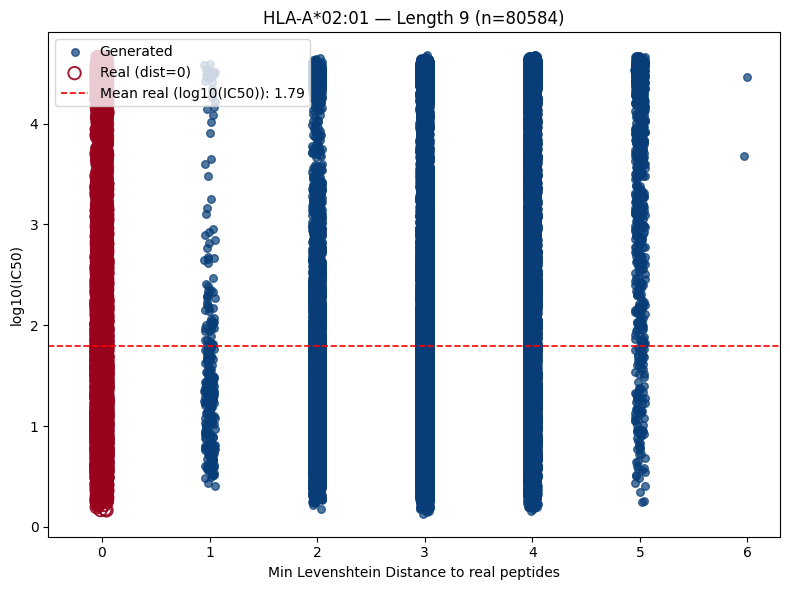

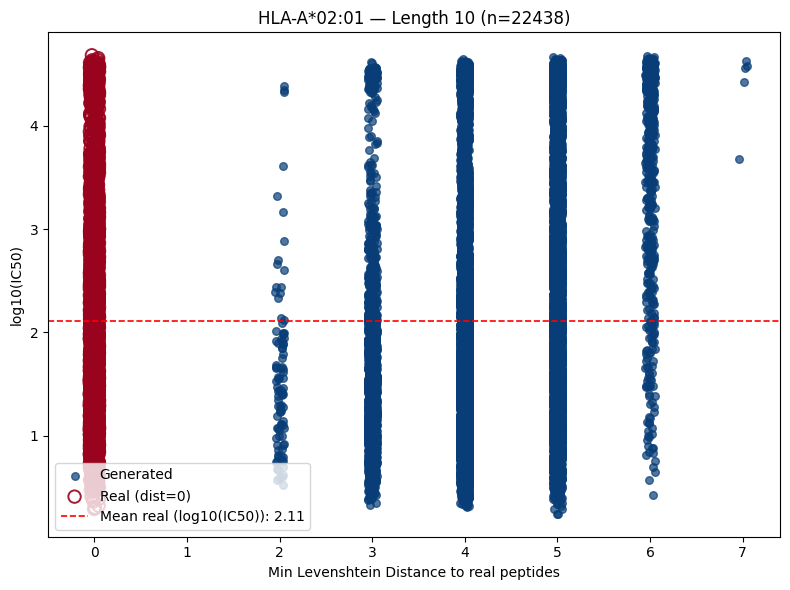

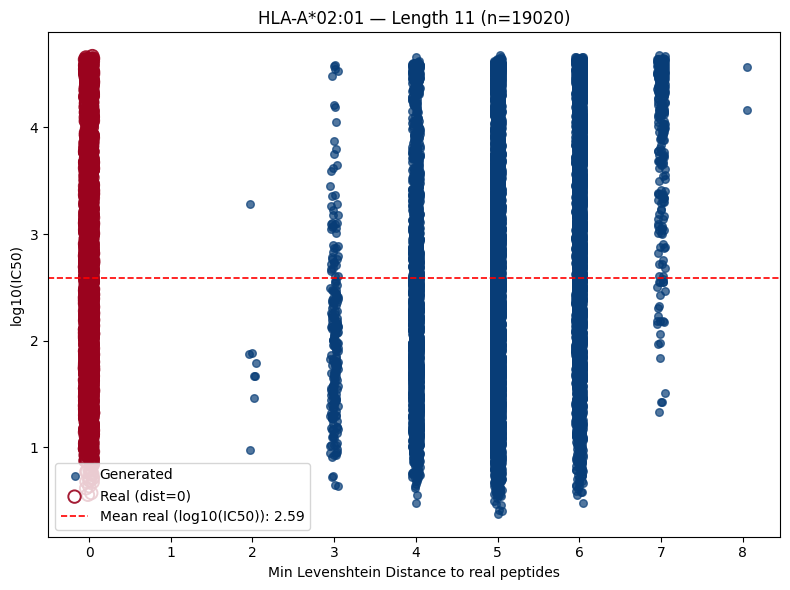

In [18]:
# --- scatter plot: IC50 (log10) vs min Levenshtein distance ---
import matplotlib.pyplot as plt
import numpy as np

palette = ['#9BC995', "#083D77", '#9A031E', '#C4B7CB', '#FC7753']  

def scatter_affinity_by_length(df_plot, length, hla, colours=palette, use_log=True):
    df_len = df_plot[df_plot["Length"] == length].copy()
    if df_len.empty:
        print(f"No data for length {length}")
        return

    # prefer Aff column (IC50). fallback to Rank
    if df_len["Aff"].notna().any():
        y = pd.to_numeric(df_len["Aff"], errors="coerce")
        ylab = "IC50 (nM)"
        if use_log:
            y = np.log10(y.replace(0, np.nan))
            ylab = "log10(IC50)"
    elif df_len["Rank"].notna().any():
        y = pd.to_numeric(df_len["Rank"], errors="coerce")
        ylab = "Percentile rank"
    else:
        print("No Aff or Rank available to plot for length", length)
        return

    df_len = df_len.assign(_y=y.values)
    real_mask = df_len["Levenshtein Distance"] == 0
    gen_mask = df_len["Levenshtein Distance"] > 0

    jitter = 0.05
    gen_x = df_len.loc[gen_mask, "Levenshtein Distance"].astype(float).values + np.random.uniform(-jitter, jitter, size=gen_mask.sum())
    gen_y = df_len.loc[gen_mask, "_y"].values

    real_x = df_len.loc[real_mask, "Levenshtein Distance"].astype(float).values + np.random.uniform(-jitter, jitter, size=real_mask.sum())
    real_y = df_len.loc[real_mask, "_y"].values

    plt.figure(figsize=(8,6))
    plt.scatter(gen_x, gen_y, s=30, alpha=0.7, color=colours[1], label="Generated")
    # real peptides as open circles with stronger edge
    plt.scatter(real_x, real_y, s=80, alpha=0.9, facecolors='none', edgecolors=colours[2], linewidths=1.4, label="Real (dist=0)")

    if real_mask.sum() > 0:
        avg_real = np.nanmean(real_y)
        plt.axhline(avg_real, color='red', linestyle='--', linewidth=1.2, label=f"Mean real ({ylab}): {avg_real:.2f}")

    plt.xlabel("Min Levenshtein Distance to real peptides")
    plt.ylabel(ylab)
    plt.title(f"{hla} — Length {length} (n={len(df_len)})")
    plt.xlim(left=-0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# call plotting for lengths you want
for length in [9, 10, 11]:
    scatter_affinity_by_length(df_plot, length=length, hla=ALLELE)


In [19]:
# quick inspection (optional)
print("df_plot columns:", list(df_plot.columns))
# Ensure Rank exists (try lowercase fallback)
if 'Rank' not in df_plot.columns and 'rank' in df_plot.columns:
    df_plot['Rank'] = df_plot['rank']

# Ensure Affinity exists (try lowercase fallback)
if 'Affinity' not in df_plot.columns and 'aff' in df_plot.columns:
    df_plot['Affinity'] = df_plot['aff']

# Make numeric
df_plot['Rank'] = pd.to_numeric(df_plot.get('Rank', pd.Series(np.nan)), errors='coerce')
df_plot['Affinity'] = pd.to_numeric(df_plot.get('Affinity', pd.Series(np.nan)), errors='coerce')

# Classification using Rank first, fallback to Affinity (IC50)
def classify_binder(row):
    r = row.get('Rank', np.nan)
    if not np.isnan(r):
        if r <= 0.5:
            return 'Strong'
        elif r <= 2.0:
            return 'Weak'
        else:
            return 'Non'
    a = row.get('Affinity', np.nan)
    if not np.isnan(a):
        if a <= 50:
            return 'Strong'
        elif a <= 500:
            return 'Weak'
        else:
            return 'Non'
    return 'Unknown'

# Create Binder column
df_plot['Binder'] = df_plot.apply(classify_binder, axis=1)

# Quick check
print("Binder counts:\n", df_plot['Binder'].value_counts(dropna=False))


df_plot columns: ['HLA', 'Peptide', 'Length', 'Levenshtein Distance', 'Aff', 'Rank', 'Source']
Binder counts:
 Binder
Strong     58392
Non        33265
Weak       23103
Unknown    11108
Name: count, dtype: int64


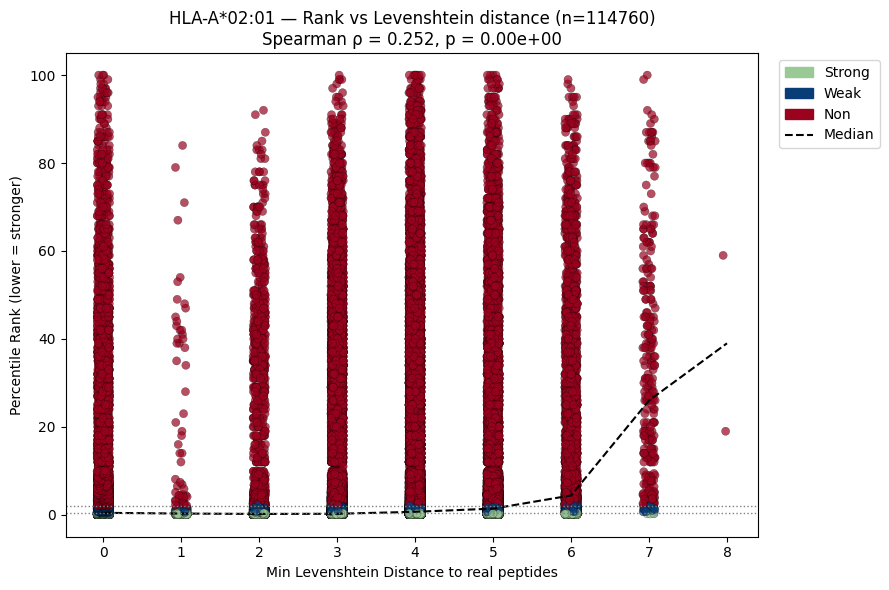

Saved: netmhcBenchmark\rank_vs_distance_scatter_HLA-A02:01.png


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats import spearmanr

# ensure needed columns exist
if 'Rank' not in df_plot.columns:
    df_plot['Rank'] = pd.to_numeric(df_plot.get('rank', np.nan), errors='coerce')

# drop rows without Rank or Distance
plot_df = df_plot.dropna(subset=['Rank', 'Levenshtein Distance']).copy()
if plot_df.empty:
    print("No rows with both Rank and Levenshtein Distance to plot.")
else:
    palette = {'Strong':'#9BC995', 'Weak':'#083D77', 'Non':'#9A031E', 'Unknown':'#C4B7CB'}
    
    plt.figure(figsize=(9,6))
    jitter = 0.08
    xs = plot_df['Levenshtein Distance'].astype(float).values + np.random.uniform(-jitter, jitter, size=len(plot_df))
    ys = plot_df['Rank'].astype(float).values
    colors = [palette.get(b, palette['Unknown']) for b in plot_df.get('Binder', pd.Series('Unknown')).fillna('Unknown').values]
    
    # <- FIXED: remove duplicate 'linewidth' kwarg, keep linewidths
    plt.scatter(xs, ys, c=colors, s=35, alpha=0.7, edgecolors='k', linewidths=0.2)
    
    # trend line: median Rank per integer distance
    medians = plot_df.groupby('Levenshtein Distance')['Rank'].median().reset_index()
    plt.plot(medians['Levenshtein Distance'], medians['Rank'], linestyle='--', color='black', linewidth=1.5, label='Median rank per distance')
    
    # Spearman correlation
    try:
        rho, pval = spearmanr(plot_df['Levenshtein Distance'].astype(float), plot_df['Rank'].astype(float), nan_policy='omit')
        corr_text = f"Spearman ρ = {rho:.3f}, p = {pval:.2e}"
    except Exception as e:
        corr_text = f"Spearman error: {e}"
    
    # threshold lines for rank classification
    plt.axhline(0.5, color='gray', linestyle=':', linewidth=1)
    plt.axhline(2.0, color='gray', linestyle=':', linewidth=1)
    
    plt.xlabel('Min Levenshtein Distance to real peptides')
    plt.ylabel('Percentile Rank (lower = stronger)')
    plt.title(f'{ALLELE} — Rank vs Levenshtein distance (n={len(plot_df)})\n{corr_text}')
    
    # custom legend for binder classes
    legend_patches = []
    for k, c in palette.items():
        if k in plot_df.get('Binder', pd.Series()).values:
            legend_patches.append(mpatches.Patch(color=c, label=k))
    # add median line entry
    from matplotlib.lines import Line2D
    median_line = Line2D([0], [0], color='black', linestyle='--', label='Median')
    
    plt.legend(handles=legend_patches + [median_line], bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    outp = os.path.join(OUTPUT_DIR, f"rank_vs_distance_scatter_{ALLELE.replace('*','')}.png")
    plt.savefig(outp, dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved:", outp)


In [21]:

palette = {'Strong':'#9BC995', 'Weak':'#083D77', 'Non':'#9A031E', 'Unknown':'#C4B7CB'}

# ensure Affinity column exists
if 'Affinity' not in df_plot.columns and 'aff' in df_plot.columns:
    df_plot['Affinity'] = pd.to_numeric(df_plot['aff'], errors='coerce')
else:
    df_plot['Affinity'] = pd.to_numeric(df_plot.get('Affinity', pd.Series(np.nan)), errors='coerce')

for length in [9, 10, 11]:
    plot_df = df_plot[df_plot['Length'] == length].dropna(subset=['Affinity', 'Levenshtein Distance']).copy()
    if plot_df.empty:
        print(f"No rows with both Affinity and Levenshtein Distance to plot for length {length}.")
        continue

    plt.figure(figsize=(9,6))
    jitter = 0.08
    xs = plot_df['Levenshtein Distance'].astype(float).values + np.random.uniform(-jitter, jitter, size=len(plot_df))

    raw_y = pd.to_numeric(plot_df['Affinity'], errors='coerce')
    raw_y[raw_y <= 0] = np.nan
    ys = np.log10(raw_y.values)

    # color per binder class
    colors = [palette.get(b, palette['Unknown']) for b in plot_df.get('Binder', pd.Series('Unknown')).fillna('Unknown').values]

    plt.scatter(xs, ys, c=colors, s=35, alpha=0.8, edgecolors='k', linewidths=0.25, marker='o')

    # trend line: median log10(IC50) per integer distance
    medians = plot_df.copy()
    medians['log_aff'] = np.log10(pd.to_numeric(medians['Affinity'], errors='coerce').replace({0:np.nan}))
    medians = medians.groupby('Levenshtein Distance')['log_aff'].median().reset_index().dropna()
    if not medians.empty:
        plt.plot(medians['Levenshtein Distance'], medians['log_aff'], linestyle='--', color='black', linewidth=1.5, label='Median log10(IC50)')

    plt.xlabel('Min Levenshtein Distance to real peptides')
    plt.ylabel('log10(IC50, nM)')
    plt.title(f'{ALLELE} — IC50 vs Levenshtein distance (Length {length}, n={len(plot_df)})')

    # updated legend
    legend_labels = {
        'Strong': 'Strong Binder (Rank <0.05%)',
        'Weak': 'Weak Binder (Rank <2%)',
        'Non': 'Non Binder (Rank >2%)',
        'Unknown': 'Unknown'
    }
    legend_patches = []
    for k, c in palette.items():
        if k in plot_df.get('Binder', pd.Series()).values:
            legend_patches.append(mpatches.Patch(color=c, label=legend_labels.get(k, k)))

    if not medians.empty:
        legend_patches.append(Line2D([0],[0], color='black', linestyle='--', label='Median'))

    plt.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    outp = os.path.join(OUTPUT_DIR, f"ic50_vs_distance_len{length}_{ALLELE.replace('*','')}.png")
    plt.savefig(outp, dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved:", outp)


No rows with both Affinity and Levenshtein Distance to plot for length 9.
No rows with both Affinity and Levenshtein Distance to plot for length 10.
No rows with both Affinity and Levenshtein Distance to plot for length 11.


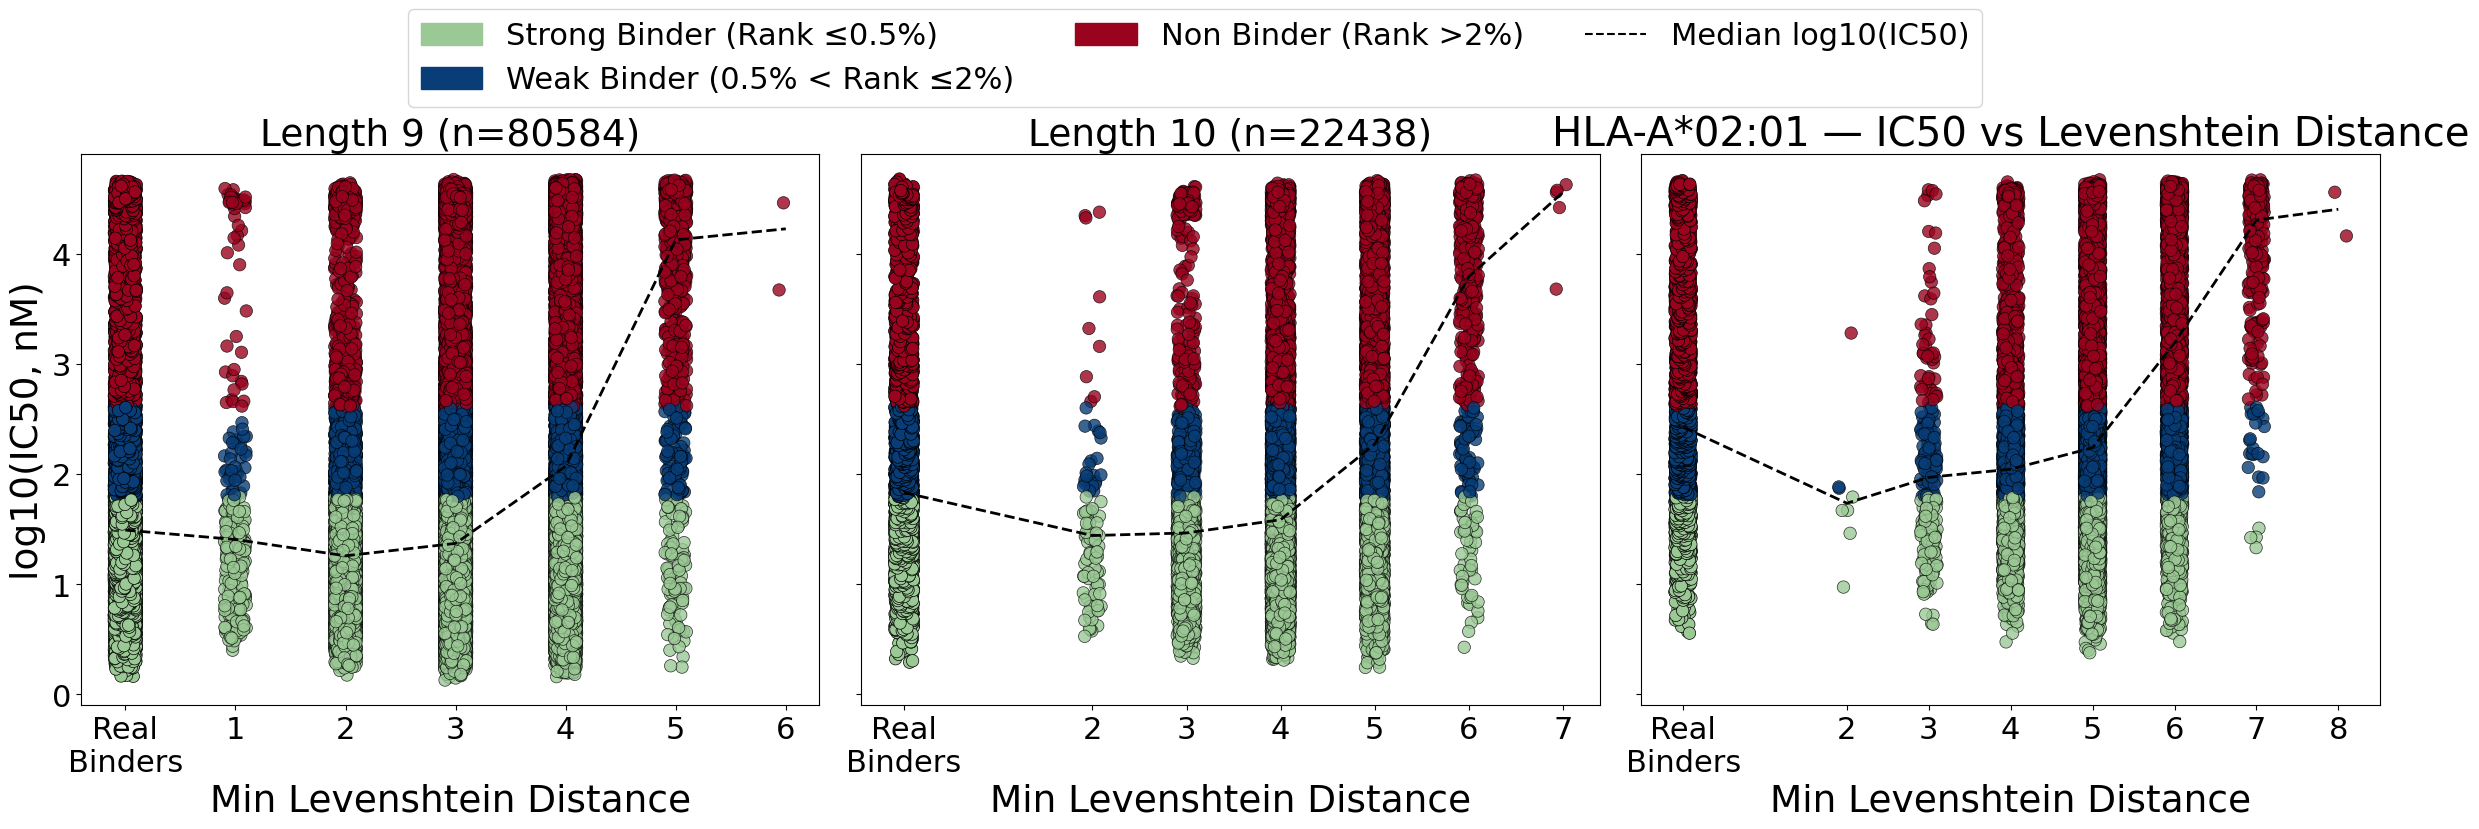

Saved: netmhcBenchmark\ic50_vs_distance_sidebyside_HLA-A02:01.png


In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import os

lengths = [9, 10, 11]
palette = {
    'Strong':'#9BC995',
    'Weak':'#083D77',
    'Non':'#9A031E',
    'Unknown':'#C4B7CB'
}

label_size = 27
title_size = 27
tick_size = 22
legend_size = 22

fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

for ax, length in zip(axes, lengths):
    plot_df = df_plot[df_plot['Length'] == length].copy()
    if plot_df.empty:
        print(f"No data for length {length}")
        continue

    def binder_category(r):
        if pd.isna(r): return 'Unknown'
        if r <= 0.5: return 'Strong'
        elif r <= 2.0: return 'Weak'
        else: return 'Non'

    plot_df['Binder'] = plot_df['Rank'].apply(binder_category)
    plot_df['Aff_num'] = pd.to_numeric(plot_df['Aff'], errors='coerce')
    plot_df.loc[plot_df['Aff_num'] <= 0, 'Aff_num'] = np.nan

    jitter = 0.1
    xs = plot_df['Levenshtein Distance'].astype(float).values + \
         np.random.uniform(-jitter, jitter, size=len(plot_df))
    ys = np.log10(plot_df['Aff_num'].values)
    colors = [palette[b] for b in plot_df['Binder']]
    alphas = np.where(plot_df['Levenshtein Distance'] == 0, 1.0, 0.8)

    ax.scatter(xs, ys, c=colors, s=80, alpha=alphas,
               edgecolors='k', linewidths=0.5, marker='o')

    medians = plot_df.groupby('Levenshtein Distance')['Aff_num'].median().dropna()
    if not medians.empty:
        ax.plot(medians.index, np.log10(medians.values),
                linestyle='--', color='black', linewidth=2, label='Median log10(IC50)')

    xticks = sorted(plot_df['Levenshtein Distance'].unique())
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        ["Real\nBinders" if x == 0 else str(int(x)) for x in xticks],
        fontsize=tick_size
    )
    ax.set_xlabel('Min Levenshtein Distance', fontsize=label_size)
    ax.set_title(f'Length {length} (n={len(plot_df)})', fontsize=title_size)
    ax.tick_params(axis='both', labelsize=tick_size)

axes[0].set_ylabel('log10(IC50, nM)', fontsize=label_size)

legend_elements = [
    mpatches.Patch(color=palette['Strong'], label='Strong Binder (Rank ≤0.5%)'),
    mpatches.Patch(color=palette['Weak'], label='Weak Binder (0.5% < Rank ≤2%)'),
    mpatches.Patch(color=palette['Non'], label='Non Binder (Rank >2%)'),
    Line2D([0],[0], color='black', linestyle='--', label='Median log10(IC50)')
]

fig.legend(handles=legend_elements,
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 1.05),
           fontsize=legend_size)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.title(f'{ALLELE} — IC50 vs Levenshtein Distance', fontsize=title_size + 2)

outp = os.path.join(OUTPUT_DIR, f"ic50_vs_distance_sidebyside_{ALLELE.replace('*','')}.png")
plt.savefig(outp, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", outp)
